In [3]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Software patents
1. Get all software patents
2. Sample within Computers; indicate whether the *tp* or *op* is a software patent

Code mostly taken from https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/Results/Regressions/1-NewSample.ipynb
and https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/Results/ExogSpillovers/2a-UniversityPatents-v2.ipynb#2.-Bayh-Dole-Sample

In [2]:
# 1. Software in abstract
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas()
print(len(pabs))
pabs = pabs.loc[pabs["abs_stemmed"].str.contains('software|softwar', regex=True)]
print(len(pabs))
sw_pats = pabs["patent"]
print(len(sw_pats))
sw_pats.to_pickle("DataStore/2018-07-P2/Software/sw_pats.pkl")
# del(pabs)

2575725
28249
28249


In [2]:
# Load data
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas()
print(len(pdf))
pdf = pdf.drop_duplicates("patent")
# Remove actual duplicates
dup_pats = pd.read_pickle("RawData/Cleaned/duplicate_pattext_0712.pkl")
pdf = pdf.loc[~(pdf["patent"].isin(dup_pats))]
print(len(pdf))
# Check that I have vector data for them
pabs = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
pdf = pdf.loc[pdf["patent"].isin(pabs)]
print(len(pdf))
del(dup_pats, pabs)

2523739
2220706
2002788


In [3]:
def get_year_group(x):
    if x in range(1975,1980):
        yg = "1975-80"
    elif x in range(1980,1985):
        yg = "1980-85"
    elif x in range(1985, 1990):
        yg = "1985-90"
    elif x in range(1990,1995):
        yg = "1990-95"
    elif x in range(1995,2000):
        yg = "1995-00"
    elif x in range(2000,2005):
        yg = "2000-05"
    elif x in range(2005,2010):
        yg = "2005-10"
    elif x in range(2010, 2015):
        yg = "2010-15"
    else:
        yg = np.nan
    return yg

pdf["year_group"] = pdf["appyear"].apply(get_year_group)
# Drop missing columns
pdf = pdf.dropna(how="any",subset=["appyear", "naics_name", "primclass", "year_group"])
print(len(pdf))

1521233


In [12]:
c = "naics_name"
k = "year_group"
m = "inv_msa"
yr_min = 1990
yr_max = 2006
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Software/sw_pats.pkl")
ind = ["Computer and Peripheral Equipment"]

uni2 = pdf.loc[pdf[c].isin(ind) & pdf["patent"].isin(sw_pats) \
               & (pdf["appyear"].isin(range(yr_min, yr_max))),
              ["patent", "inv_msa", "appyear", "year_group", "naics_name", "primclass"]].copy().reset_index(drop=True)
uni2["tp_is_sw"] = True
p_rel = pdf.loc[pdf[c].isin(ind) & (pdf["appyear"].isin(range(yr_min, yr_max))), uni2.columns]
p2 = p_rel.sample(frac=0.6).reset_index(drop=True)
p2["tp_is_sw"] = False
targ = uni2.append(p2, ignore_index=True).reset_index(drop=True)
del(p2, uni2)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [13]:
targ_g = targ.groupby([c,k,m]) # Each group is from same field, MSA, year group
p_c_m = p_rel.groupby([c,k,m]) # Each group is from same field, MSA, year group
p_c = p_rel.groupby([c,k]) # Each group from the same field, year group
ts = pd.DataFrame()
for n,g in targ_g:
    # Propagate the target patents
    # Get num x existing patent lists and randomize them
    num = 20
    p_all = []
    for i in range(num):
        p_all.extend(g["patent"].tolist())
    tp_in_msa = p_all
    if n in p_c_m.groups.keys():
        op_in_msa = p_c_m.get_group(n)["patent"].sample(n=len(tp_in_msa), replace=True).tolist()
        in_msa = pd.DataFrame({"tp": tp_in_msa, "op": op_in_msa})
        in_msa["samp"] = "In MSA"
    else:
        in_msa = pd.DataFrame()
    if (n[0], n[1]) in p_c.groups.keys():
        op_in_field = p_c.get_group((n[0], n[1]))["patent"].sample(n=len(tp_in_msa), replace=True).tolist()
        in_field = pd.DataFrame({"tp": tp_in_msa, "op": op_in_field})
        in_field["samp"] = "In Field"
    else:
        in_field = pd.DataFrame()   
    
    # Merge
    samp = pd.concat([in_msa, in_field], axis=0)
    if len(samp) > 0:
        # Remove where other is less than target
        samp = samp.loc[(samp["tp"] < samp["op"])]
        ts = ts.append(samp, ignore_index = True)

print(len(ts))

1377158


In [14]:
asgs = pickle.load(open("RawData/Cleaned/patent_assignee_dict_0628.pkl", "rb"))
# Check that target and other do not have same assignee
%time asg_match = (set(asgs.get(tp, [])).intersection(asgs.get(op, [])) for tp, op in zip(ts["tp"], ts["op"]))
%time asg_match = [len(i) for i in asg_match]

ts["asg_match"] = asg_match
ts = ts.loc[ts["asg_match"] == 0]
ts = ts.drop("asg_match",1)
print(len(ts))
del(asgs)

CPU times: user 59.3 ms, sys: 21.8 ms, total: 81.1 ms
Wall time: 80.6 ms
CPU times: user 2.42 s, sys: 8.72 ms, total: 2.43 s
Wall time: 2.42 s
1231274


In [15]:
ts.to_pickle("DataStore/2018-07-P2/Software/computer_sw_samp_0723.pkl")

## 2. Location measures
### 2.1. Location distributions of new patents at each year

In [4]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
sw_pats = pd.read_pickle("DataStore/2018-07-P2/Software/sw_pats.pkl")
sw_pats = pdf.loc[pdf["patent"].isin(sw_pats)]
del(pdf)

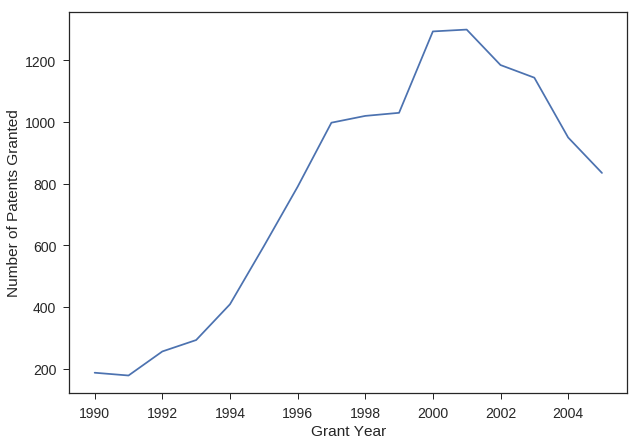

In [5]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-07-P3/ResultsGraphs/"

yr_min = 1990
yr_max = 2005

num_u = sw_pats.loc[sw_pats["appyear"].isin(range(yr_min, yr_max+1)), "appyear"].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(10,7))
num_u.plot.line(ax = ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("Number of Patents Granted")

# plt.savefig(savepath+"4a-SoftwarePatSize.png")
plt.show()

In [6]:
yr_min = 1990
yr_max = 2005
p3 = sw_pats.loc[(sw_pats["appyear"] >= yr_min) & (sw_pats["appyear"] <= yr_max)]
ploc = p3[["inv_msa", "appyear", "patent"]].groupby(["inv_msa", "appyear"]).count().reset_index()
# Only use those places with greater than 10 patents
ploc = ploc.loc[ploc["patent"] >= 10]
ploc = ploc.pivot(index="appyear", columns="inv_msa", values="patent").fillna(0)

# Get proportions
ploc = ploc.apply(lambda x: x/x.sum(), axis=1)

# Get number of cities
print(len(ploc.columns))

31


In [7]:
sim = 1-sp.spatial.distance.cdist(ploc.values,ploc.values,metric="cosine")
# Make dataframe
sim = pd.DataFrame(sim, columns=list(range(yr_min,yr_max+1)), index=list(range(yr_min,yr_max+1))).unstack().reset_index()
sim.columns=["appyear1", "appyear2", "sim_location"]
sim["lag"] = sim["appyear2"]-sim["appyear1"]

In [8]:
# Timeline of lag1
sim1 = sim.loc[sim["lag"] == 1, ["appyear1", "sim_location"]].set_index("appyear1")

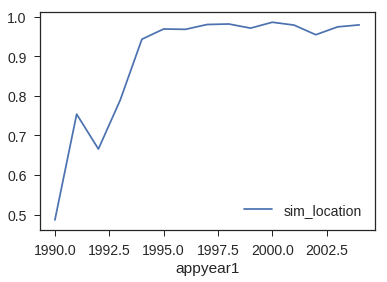

In [9]:
%matplotlib inline
# Plot
sim1.plot.line()

### 2.2 HHI

In [10]:
hhi = pd.Series(np.sum(ploc.values**2,axis=1), index = list(range(yr_min,yr_max+1)))

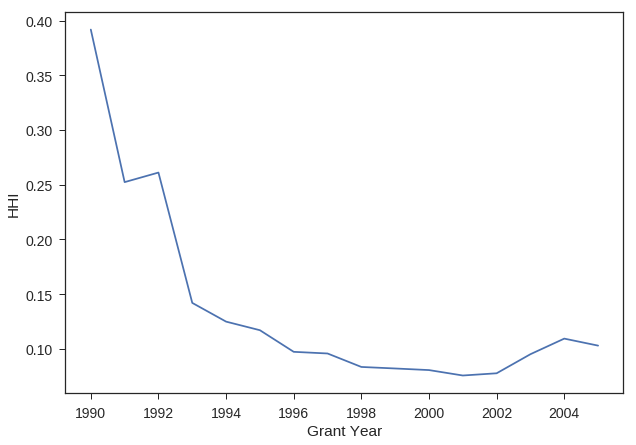

In [11]:
%matplotlib inline
# Plot
fig, ax = plt.subplots(figsize=(10,7))
hhi.plot.line(ax=ax)
ax.set_xlabel("Grant Year")
ax.set_ylabel("HHI")
plt.savefig(savepath+"1a-HHI_Software.png")
plt.show()